In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import mplhep as hep
hep.style.use("CMS")

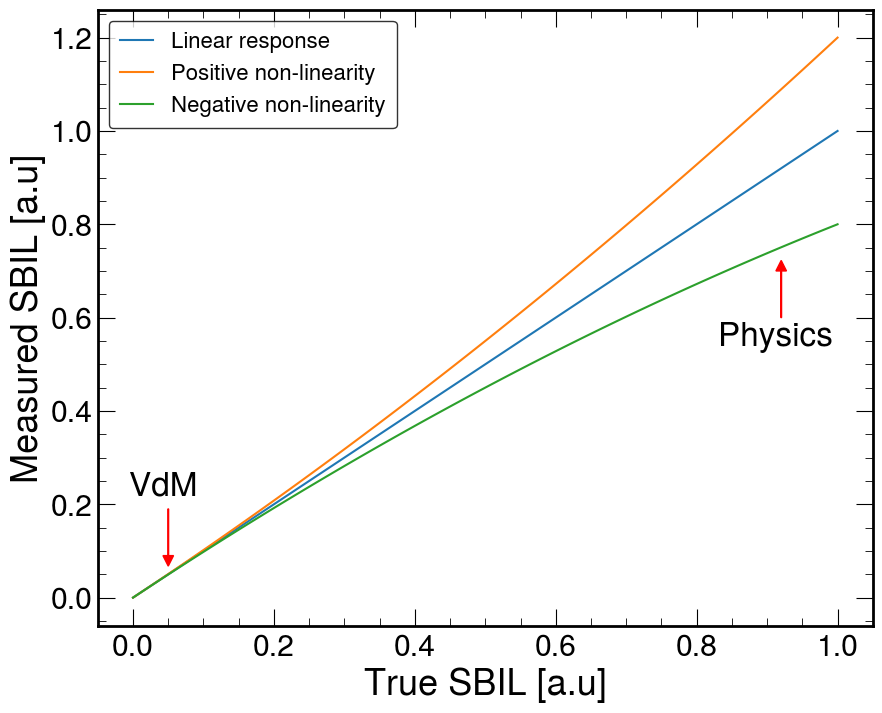

In [21]:
plt.figure(figsize=(10,8))
plt.ylabel("Measured SBIL [a.u]", loc="center")
plt.xlabel("True SBIL [a.u]", loc="center")

x = np.linspace(0, 1, 100)
y_linear = x
y_positive = x + x**2 * (+0.2)
y_negative = x + x**2 * (-0.2)
plt.plot(x, y_linear, label="Linear response")
plt.plot(x, y_positive, label="Positive non-linearity")
plt.plot(x, y_negative, label="Negative non-linearity")
plt.text(-0.005, 0.22, "VdM", fontsize=24)
plt.arrow(0.05, 0.19, 0, -0.1, head_width=0.015, color="red")
plt.text(0.83, 0.54, "Physics", fontsize=24)
plt.arrow(0.92, 0.6, 0, 0.1, head_width=0.015, color="red")



plt.legend(fontsize=16, edgecolor="black", frameon=True, facecolor="white")
plt.savefig("msc_latex_template/images/assets/non_linearity_diagram.pdf")
plt.show()


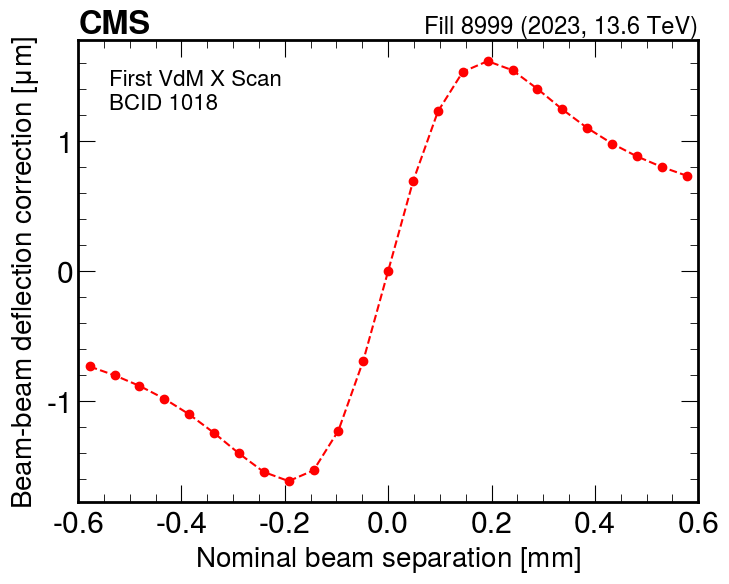

In [16]:
import json

with open("beam.json") as fp:
    data = json.load(fp)

plane_corr = []
scan = 1
bcid = 1018
plane = "X" if scan == 1 else "Y"
for sp in data[f"Scan_{scan}"]:
    plane_corr.append(sp[f"corr_{plane}coord"][str(bcid)] * 1000)

plt.figure(figsize=(8, 6))
hep.cms.label(llabel="", fontsize=18, rlabel="Fill 8999 (2023, 13.6 TeV)")
plt.text(0.05, 0.85, f"First VdM {plane} Scan\nBCID {bcid}", transform=plt.gca().transAxes, fontsize=16, fontname='sans-serif')
seps = [
    -0.577758, -0.529611, -0.481465, -0.433318, -0.385172,
    -0.337025, -0.288879, -0.240732, -0.192586, -0.144439,
    -0.096293, -0.048146,      -0.0,  0.048146,  0.096293,
     0.144439,  0.192586,  0.240732,  0.288879,  0.337025,
     0.385172,  0.433318,  0.481465,  0.529611,  0.577758
]
plt.plot(seps, plane_corr, "--o", color="red", label="x plane")
plt.xlabel("Nominal beam separation [$mm$]", loc="center", fontsize=20)
plt.ylabel("Beam-beam deflection correction [$\mu m$]", loc="center", fontsize=20)
plt.xlim(-0.6, 0.6)
plt.savefig("msc_latex_template/images/assets/beam_beam_correction.pdf")
plt.show()

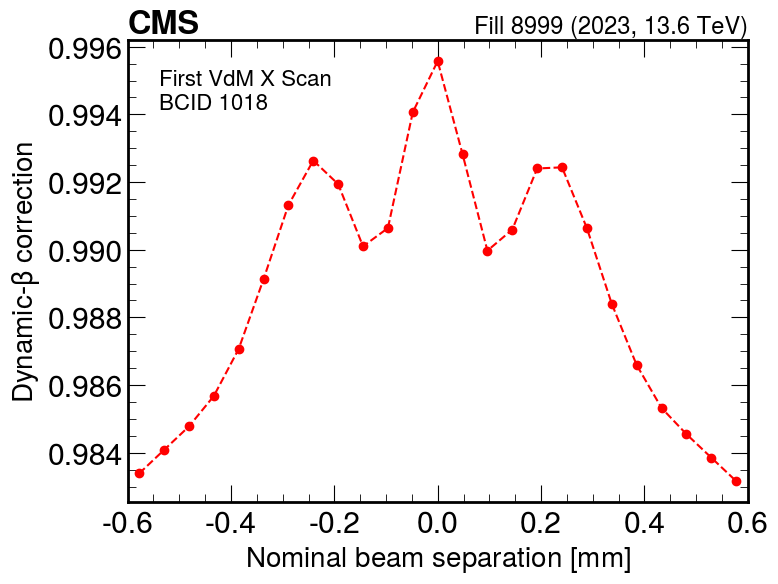

In [17]:
import json

with open("dynamic.json") as fp:
    data = json.load(fp)

plane_corr = []
plane = "X" if scan == 1 else "Y"
for sp_val in data[f"Scan_{scan}_{plane}1"][str(bcid)]:
    plane_corr.append(sp_val[1])

plt.figure(figsize=(8, 6))
hep.cms.label(llabel="", fontsize=18, rlabel="Fill 8999 (2023, 13.6 TeV)")
plt.text(0.05, 0.85, f"First VdM {plane} Scan\nBCID {bcid}", transform=plt.gca().transAxes, fontsize=16, fontname='sans-serif')
seps = [
    -0.577758, -0.529611, -0.481465, -0.433318, -0.385172,
    -0.337025, -0.288879, -0.240732, -0.192586, -0.144439,
    -0.096293, -0.048146,      -0.0,  0.048146,  0.096293,
     0.144439,  0.192586,  0.240732,  0.288879,  0.337025,
     0.385172,  0.433318,  0.481465,  0.529611,  0.577758
]
plt.plot(seps, plane_corr, "--o", color="red", label="x plane")
plt.xlabel("Nominal beam separation [$mm$]", loc="center", fontsize=20)
plt.ylabel(r"Dynamic-$\beta$ correction", loc="center", fontsize=20)
plt.xlim(-0.6, 0.6)
plt.savefig("msc_latex_template/images/assets/dynmic_beta_correction.pdf")
plt.show()

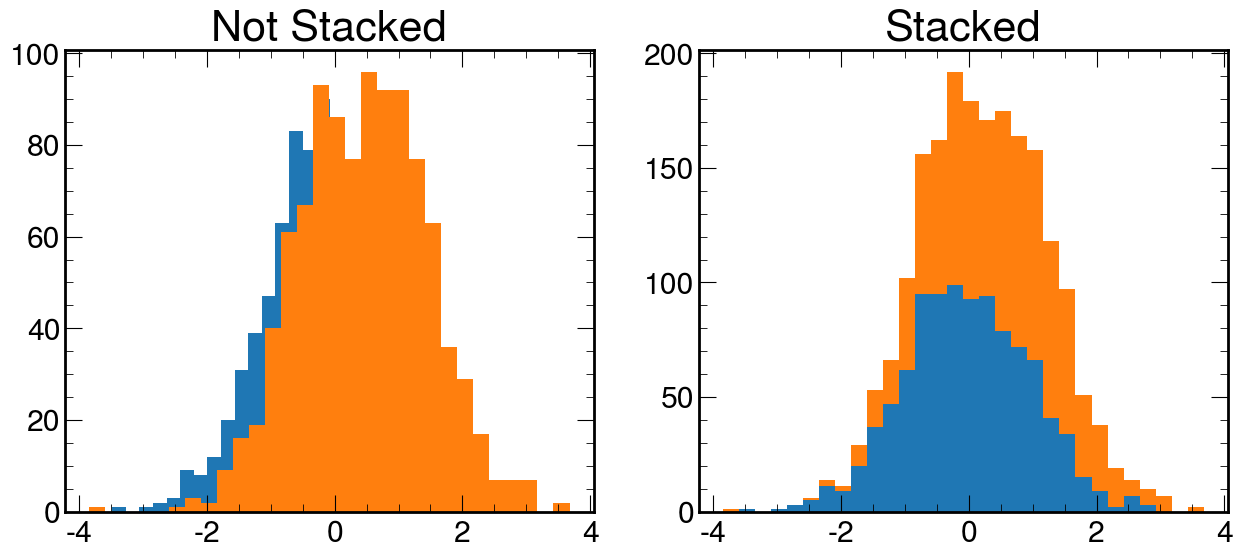

In [40]:
import numpy as np
import matplotlib.pyplot as plt

d1 = np.random.normal(0, 1, 1000)
d2 = np.random.normal(0.5, 1, 1000)


fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Even if I set stacked=True it will ont stack
axs[0].hist(d1, bins=30, stacked=True)
axs[0].hist(d2, bins=30, stacked=True)
axs[0].set_title("Not Stacked")

# if I pass both distributions at the same time it will stack
axs[1].hist([d1, d2], bins=30, stacked=True)
axs[1].set_title("Stacked")

plt.show()